# Download packages and setup clients

In [71]:

! pip install chembl_webresource_client --quiet
! pip install rdkit --quiet
print("Packages downloaded successfully")

Packages downloaded successfully


In [72]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
from tqdm.auto import tqdm
import math
from math import log10

In [73]:
# Create the clients
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

# Finding our target

In [74]:
uniprot_id = "P14780"
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Matrix metalloproteinase 9,CHEMBL321,SINGLE PROTEIN
1,Homo sapiens,Matrix metalloproteinase 9,CHEMBL321,SINGLE PROTEIN
2,Homo sapiens,Collagenase,CHEMBL2095216,PROTEIN FAMILY
3,Homo sapiens,Matrix metalloproteinase 2/9,CHEMBL3885505,PROTEIN FAMILY
4,Homo sapiens,MMP-2/MMP-9,CHEMBL4523972,SELECTIVITY GROUP


In [75]:
target = targets.iloc[0]
chembl_id = target.target_chembl_id
print(target)
print(f"\nThe target ChEMBL ID is {chembl_id}")

organism                          Homo sapiens
pref_name           Matrix metalloproteinase 9
target_chembl_id                     CHEMBL321
target_type                     SINGLE PROTEIN
Name: 0, dtype: object

The target ChEMBL ID is CHEMBL321


# Getting Bioactivity Data

In [76]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}")

Length and type of bioactivities object: 2318


In [77]:
bioactivities[0]

{'activity_id': 33892,
 'assay_chembl_id': 'CHEMBL715225',
 'assay_description': 'In vitro inhibitory activity against matrix metalloprotease-9.',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL80814',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '34.0',
 'target_chembl_id': 'CHEMBL321',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'nM',
 'value': '34.0'}

In [78]:
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (2318, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,33892,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL80814,=,nM,34.0,CHEMBL321,Homo sapiens,IC50,nM,34.0
1,35115,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL276119,=,nM,9.0,CHEMBL321,Homo sapiens,IC50,nM,9.0
2,35120,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78934,=,nM,20.0,CHEMBL321,Homo sapiens,IC50,nM,20.0
3,35125,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78369,=,nM,3.0,CHEMBL321,Homo sapiens,IC50,nM,3.0
4,35129,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL514138,=,nM,9.0,CHEMBL321,Homo sapiens,IC50,nM,9.0


## Cleaning our Data

In [79]:
bioactivities_df["units"].unique()

array(['nM', 'uM', 'ug ml-1'], dtype=object)

In [80]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,33892,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL80814,=,nM,34.0,CHEMBL321,Homo sapiens,IC50
1,35115,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL276119,=,nM,9.0,CHEMBL321,Homo sapiens,IC50
2,35120,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78934,=,nM,20.0,CHEMBL321,Homo sapiens,IC50
3,35125,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78369,=,nM,3.0,CHEMBL321,Homo sapiens,IC50
4,35129,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL514138,=,nM,9.0,CHEMBL321,Homo sapiens,IC50


In [81]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [82]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

In [83]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"Shape after Dropping NA: \n{bioactivities_df.shape}")
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape after cleaning: {bioactivities_df.shape}")
bioactivities_df.reset_index(drop=True, inplace=True)

Shape after Dropping NA: 
(2318, 11)
Units in downloaded data: ['nM' 'ug.mL-1']
Number of non-nM entries:    5
Units after filtering: ['nM']
DataFrame shape after cleaning: (2049, 11)


In [84]:
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,33892,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL80814,=,nM,34.0,CHEMBL321,Homo sapiens,IC50
1,35115,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL276119,=,nM,9.0,CHEMBL321,Homo sapiens,IC50
2,35120,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78934,=,nM,20.0,CHEMBL321,Homo sapiens,IC50
3,35125,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78369,=,nM,3.0,CHEMBL321,Homo sapiens,IC50
4,35129,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL514138,=,nM,9.0,CHEMBL321,Homo sapiens,IC50


In [85]:
# Rename columns
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,33892,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL80814,=,nM,34.0,CHEMBL321,Homo sapiens,IC50
1,35115,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL276119,=,nM,9.0,CHEMBL321,Homo sapiens,IC50
2,35120,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78934,=,nM,20.0,CHEMBL321,Homo sapiens,IC50
3,35125,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78369,=,nM,3.0,CHEMBL321,Homo sapiens,IC50
4,35129,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL514138,=,nM,9.0,CHEMBL321,Homo sapiens,IC50


# Get Compound Data

In [86]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [87]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/2049 [00:00<?, ?it/s]

In [88]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2049, 2)


In [89]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL2,{'canonical_smiles': 'COc1cc2nc(N3CCN(C(=O)c4c...
1,CHEMBL268377,{'canonical_smiles': 'COc1ccc(S(=O)(=O)N2CN(C(...
2,CHEMBL7108,{'canonical_smiles': 'COc1ccc(S(=O)(=O)N2CN(C(...
3,CHEMBL267939,{'canonical_smiles': 'COc1ccc(S(=O)(=O)N2CCN(C...
4,CHEMBL415482,{'canonical_smiles': 'COc1ccc(S(=O)(=O)N2CCN(C...


## Preprocess Compound Data

In [90]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape after dropping na: {compounds_df.shape}")
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape after dropping dupes: {compounds_df.shape}")

DataFrame shape after dropping na: (2049, 2)
DataFrame shape after dropping dupes: (2049, 2)


In [91]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [92]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2049, 2)


# Bioactivity and Compound Data

In [93]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 2049


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [94]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 2049


Index(['molecule_chembl_id', 'smiles'], dtype='object')

In [95]:
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 2049 entries.


In [96]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [97]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL80814,34.0,nM,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...
1,CHEMBL276119,9.0,nM,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...
2,CHEMBL78934,20.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...
3,CHEMBL78369,3.0,nM,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...
4,CHEMBL514138,9.0,nM,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...
5,CHEMBL80453,44.0,nM,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(CCCOc3ccccc3)C...
6,CHEMBL312432,6.0,nM,Cc1ccc(CN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OCc4ccc(...
7,CHEMBL306617,5.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(CCOc3ccccc3...
8,CHEMBL79111,43.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(CC)CC2)cc1
9,CHEMBL78798,2.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(OCCN...


In [98]:
def convert_ic50_to_pic50(IC50_value):
    """
    Converts IC50 values to pIC50 values.
    Handles invalid IC50 values by returning NaN.
    """
    try:
        # Attempt to calculate pIC50 if IC50 is positive
        if IC50_value > 0:
            pIC50_value = 9 - math.log10(IC50_value)
            return pIC50_value
        else:
            # Return NaN for non-positive IC50 values
            return float('nan')
    except ValueError:
        # Return NaN if any other ValueError occurs
        return float('nan')

output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)
output_df.dropna(inplace=True)
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL80814,34.0,nM,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...,7.468521
1,CHEMBL276119,9.0,nM,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...,8.045757
2,CHEMBL78934,20.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...,7.698970
3,CHEMBL78369,3.0,nM,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...,8.522879
4,CHEMBL514138,9.0,nM,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...,8.045757


array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

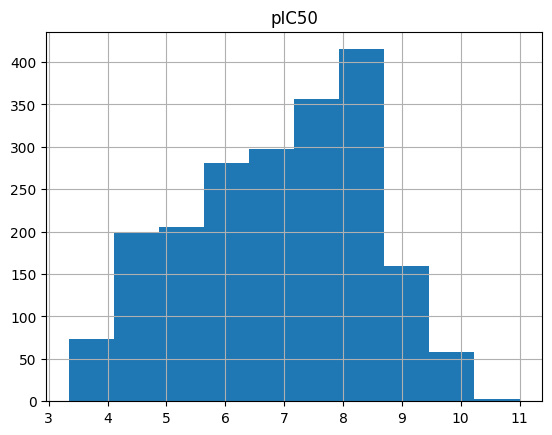

In [99]:
output_df.hist(column="pIC50")

In [100]:
output_df.drop(columns=["molecule_chembl_id", "IC50", "units"])

,smiles,pIC50
0,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...,7.468521
1,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...,8.045757
2,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...,7.698970
3,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...,8.522879
4,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...,8.045757
...,...,...
2044,CCCCCCN([C@@H](C(=O)O)C(C)C)S(=O)(=O)c1ccc(-c2...,6.482804
2045,CCCCCCCCN([C@@H](C(=O)O)C(C)C)S(=O)(=O)c1ccc(-...,5.397940
2046,Cc1ccc(-c2noc(-c3ccc(S(=O)(=O)N(Cc4ccccc4)[C@@...,7.022276
2047,Cc1ccc(-c2noc(-c3ccc(S(=O)(=O)N(CCCCCCCCCCCCN=...,6.030118


In [101]:
output_df.to_csv("~/datasets/compound_bioactivity_data.csv", index=False)